# Setup

In [1]:
# Import the package
import sys
import os

package_path = "../../funROI"
sys.path.append(os.path.abspath(package_path))

import funROI
from funROI import first_level, analysis

from funROI.utils import ParcelsConfig, FROIConfig

# Configure the paths for the dataset and analysis
funROI.set_bids_data_folder("../data/bids")
funROI.set_bids_deriv_folder("../data/bids/derivatives")
funROI.set_bids_preprocessed_folder("../data/bids/derivatives/fmriprep")
funROI.set_analysis_output_folder("../data/funroi_analysis_output")

# Import viz tools
from nilearn.plotting import plot_stat_map, plot_glass_brain

# First Level Modeling

## Nilearn first level modeling from fMRIPrep derivatives

In [2]:
from funROI.first_level.nilearn import run_first_level

confound_labels = ["trans_x", "trans_y", "trans_z", "rot_x", "rot_y", "rot_z"]
space = "MNI152NLin6Asym"

run_first_level(
    subjects=["040"],
    tasks=["EventsOrig", "SWNloc"],
    confound_labels=confound_labels,
    space=space,
    res=2,
)
run_first_level(
    subjects=["199"],
    tasks=["Events2move", "langlocSN", "spatialFIN"],
    confound_labels=confound_labels,
    space=space,
    res=2,
)

## SPM first level results to BIDS

For the demo here, we are using the precalculated SPM first level results.

The below codes migrate SPM first level results to the BIDS directory, to be

used for the following analysis.

In [3]:
!rm -r ../data/bids/derivatives/first_level_*

In [4]:
from funROI.first_level.spm import migrate_first_level_from_spm
import glob

spm_data_dir = "../data/spm_first_level_results"
for task, task_suffix in [
    ("SWNloc", "SWNlocIPS168_3runs"),
    ("EventsOrig", "EventsOrig_instrsep_2runs"),
]:
    spm_folders = glob.glob(os.path.join(spm_data_dir, f"*_{task_suffix}"))
    for spm_folder in spm_folders:
        subject_id = os.path.basename(spm_folder).split("_")[0]
        migrate_first_level_from_spm(spm_folder, subject_id, task)

# Parcels Generation

## Language Parcels

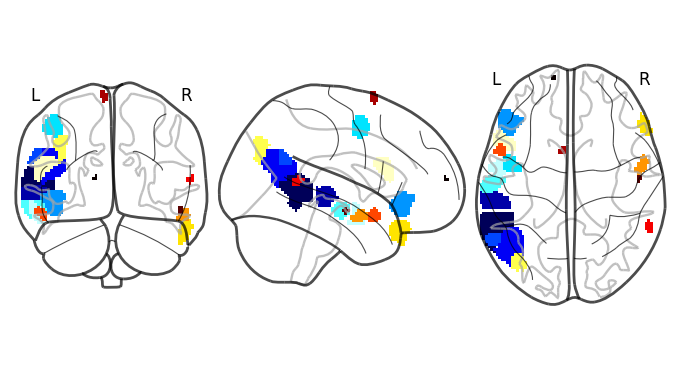

In [5]:
parcels_generator = analysis.ParcelsGenerator(
    smoothing_kernel_size=6, overlap_thr_vox=0.1, use_spm_smooth=True
)
parcels_generator.add_subjects(
    subjects=[
        "040",
        "057",
        "059",
        "056",
        "067",
        "068",
        "019",
        "070",
        "087",
        "078",
        "089",
        "076",
    ],
    task="SWNloc",
    contrasts=["S-N"],
    p_threshold_type="none",
    p_threshold_value=0.001,
)
parcels = parcels_generator.generate()
plot_glass_brain(parcels, plot_abs=False)
parcels_generator.save(parcels_name="languageSminusN")

/Users/ruimingao/Documents/funROI_all/funROI/funROI/utils.py:298: RuntimeWarning: divide by zero encountered in divide
  return len(data) / np.sum(1 / data)


Remaining parcels: 8


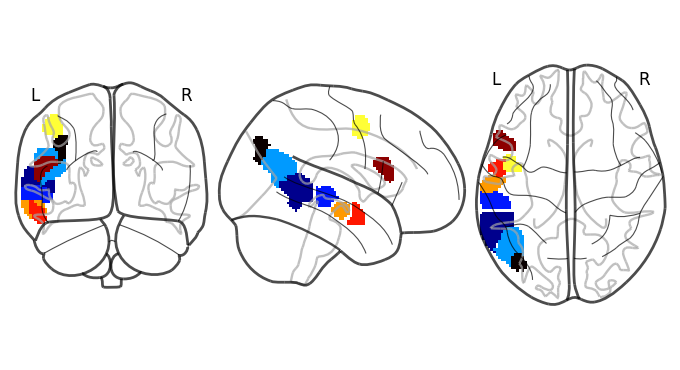

In [6]:
# Illustration of parcel thresholding
filtered_img = parcels_generator.filter(
    min_voxel_size=100, overlap_thr_roi=0.5, inplace=True
)
plot_glass_brain(filtered_img, plot_abs=False)

In [7]:
parcels_generator.save(parcels_name="languageSminusN_filtered")

## Events Parcels

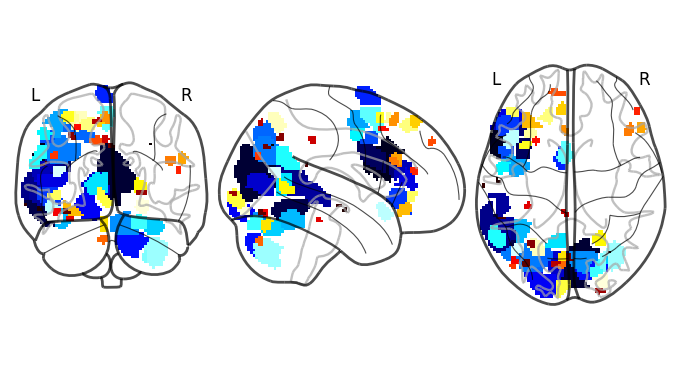

In [8]:
# Events parcels defined by sentence Sem-Perc contrast
parcels_generator = analysis.ParcelsGenerator(
    smoothing_kernel_size=6, overlap_thr_vox=0.1, use_spm_smooth=True
)
parcels_generator.add_subjects(
    subjects=[
        "040",
        "057",
        "059",
        "056",
        "067",
        "068",
        "019",
        "070",
        "087",
        "078",
        "089",
        "076",
    ],
    task="EventsOrig",
    contrasts=["Sem_sentminusPerc_sent"],
    p_threshold_type="none",
    p_threshold_value=0.05,
)
parcels = parcels_generator.generate()
plot_glass_brain(parcels, plot_abs=False)
parcels_generator.save(parcels_name="eventsSent")

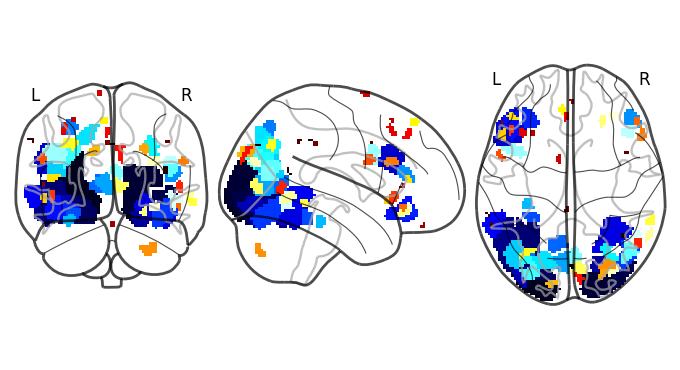

In [9]:
# Events parcels defined by photo Sem-Perc contrast
parcels_generator = analysis.ParcelsGenerator(
    smoothing_kernel_size=6, overlap_thr_vox=0.1, use_spm_smooth=True
)
parcels_generator.add_subjects(
    subjects=[
        "040",
        "057",
        "059",
        "056",
        "067",
        "068",
        "019",
        "070",
        "087",
        "078",
        "089",
        "076",
    ],
    task="EventsOrig",
    contrasts=["Sem_photominusPerc_photo"],
    p_threshold_type="none",
    p_threshold_value=0.05,
)
parcels = parcels_generator.generate()
plot_glass_brain(parcels, plot_abs=False)
parcels_generator.save(parcels_name="eventsPhoto")

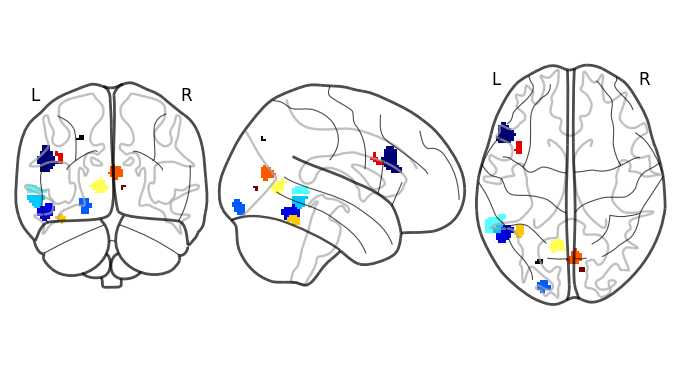

In [10]:
# Events parcels defined by both Sem-Perc contrast, conjuncted by 'and'
parcels_generator = analysis.ParcelsGenerator(
    smoothing_kernel_size=6, overlap_thr_vox=0.1, use_spm_smooth=True
)
parcels_generator.add_subjects(
    subjects=[
        "040",
        "057",
        "059",
        "056",
        "067",
        "068",
        "019",
        "070",
        "087",
        "078",
        "089",
        "076",
    ],
    task="EventsOrig",
    contrasts=["Sem_photominusPerc_photo", "Sem_sentminusPerc_sent"],
    conjunction_type="and",
    p_threshold_type="none",
    p_threshold_value=0.05,
)
parcels = parcels_generator.generate()
plot_glass_brain(parcels, plot_abs=False)
parcels_generator.save(parcels_name="eventsBoth")

# fROI Definition

In [11]:
froi_generator = analysis.FROIGenerator()

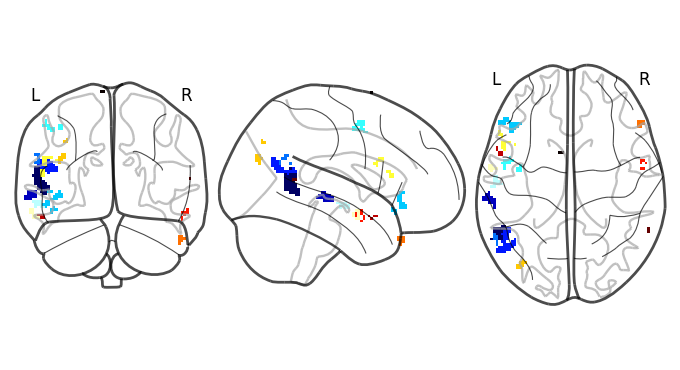

In [12]:
froi_config = FROIConfig(
    task="SWNloc",
    contrasts=["S-N"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels="languageSminusN",
)
froi_img = froi_generator.generate("040", froi_config)
plot_glass_brain(froi_img, plot_abs=False)

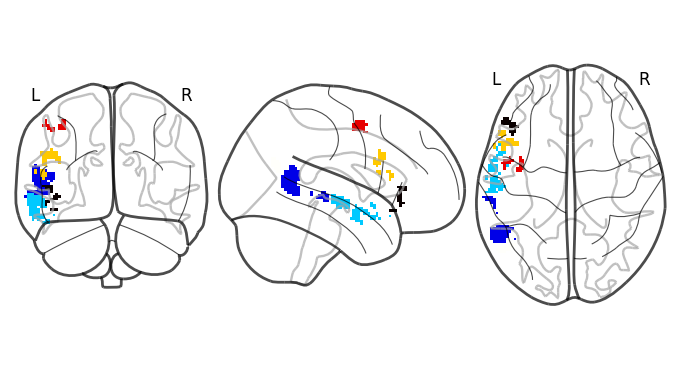

In [13]:
# Use an external parcels image
froi_config = FROIConfig(
    task="SWNloc",
    contrasts=["S-N"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels="../data/parcels/Language.nii",
)
froi_img = froi_generator.generate("040", froi_config)
plot_glass_brain(froi_img, plot_abs=False)

# fROI Effect Estimation

In [14]:
froi_config = FROIConfig(
    task="SWNloc",
    contrasts=["S-N"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels="../data/parcels/Language.nii",
)

froi_effect_estimator = analysis.FROIEffectEstimator(
    subjects=[
        "040",
        "057",
        "059",
        "056",
        "067",
        "068",
        "019",
        "070",
        "087",
        "078",
        "089",
        "076",
    ],
    froi=froi_config,
)

froi_effect_estimator.run(
    [
        ("SWNloc", ["S", "W", "N"]),
        ("EventsOrig", ["Sem_photo", "Perc_photo", "Sem_sent", "Perc_sent"]),
    ],
)

In [15]:
# Use labeled parcels
parcels_config = ParcelsConfig(
    parcels_path="../data/parcels/Language.nii",
    labels_path="../data/parcels/Language_labels.json",
)

froi_config = FROIConfig(
    task="SWNloc",
    contrasts=["S-N"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels=parcels_config,
)

froi_effect_estimator = analysis.FROIEffectEstimator(
    subjects=[
        "040",
        "057",
        "059",
        "056",
        "067",
        "068",
        "019",
        "070",
        "087",
        "078",
        "089",
        "076",
    ],
    froi=froi_config,
)

froi_effect_estimator.run(
    [
        ("SWNloc", ["S", "W", "N"]),
        ("EventsOrig", ["Sem_photo", "Perc_photo", "Sem_sent", "Perc_sent"]),
    ]
)

# Spatial Correlation Estimation

In [16]:
# Use fROIs by parcels
parcels_config = ParcelsConfig(
    parcels_path="../data/parcels/Language.nii",
    labels_path="../data/parcels/Language_labels.json",
)

spcorr_estimator = analysis.SpatialCorrelationEstimator(
    subjects=[
        "040",
        "057",
        "059",
        "056",
        "067",
        "068",
        "019",
        "070",
        "087",
        "078",
        "089",
        "076",
    ],
    froi=parcels_config,
)

spcorr_estimator.run(
    [
        ("SWNloc", ["S", "W", "N"]),
        ("EventsOrig", ["Sem_photo", "Perc_photo", "Sem_sent", "Perc_sent"]),
    ]
)

In [17]:
# Use fROIs by localizers
parcels_config = ParcelsConfig(
    parcels_path="../data/parcels/Language.nii",
    labels_path="../data/parcels/Language_labels.json",
)

froi_config = FROIConfig(
    task="SWNloc",
    contrasts=["S-N"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels=parcels_config,
)

spcorr_estimator = analysis.SpatialCorrelationEstimator(
    subjects=[
        "040",
        "057",
        "059",
        "056",
        "067",
        "068",
        "019",
        "070",
        "087",
        "078",
        "089",
        "076",
    ],
    froi=froi_config,
)

spcorr_estimator.run(
    [
        ("SWNloc", ["S", "W", "N"]),
        ("EventsOrig", ["Sem_photo", "Perc_photo", "Sem_sent", "Perc_sent"]),
    ]
)

/Users/ruimingao/Documents/funROI_all/funROI/funROI/analysis/spcorr.py:150: UserWarning: Subject 040: skipping spatial correlation between SWNloc S and SWNloc S because they are not orthogonal to each other, and both not orthogonal to fROI.
  warnings.warn(
/Users/ruimingao/Documents/funROI_all/funROI/funROI/analysis/spcorr.py:150: UserWarning: Subject 040: skipping spatial correlation between SWNloc S and SWNloc N because they are not orthogonal to each other, and both not orthogonal to fROI.
  warnings.warn(
/Users/ruimingao/Documents/funROI_all/funROI/funROI/analysis/spcorr.py:150: UserWarning: Subject 040: skipping spatial correlation between SWNloc N and SWNloc S because they are not orthogonal to each other, and both not orthogonal to fROI.
  warnings.warn(
/Users/ruimingao/Documents/funROI_all/funROI/funROI/analysis/spcorr.py:150: UserWarning: Subject 040: skipping spatial correlation between SWNloc N and SWNloc N because they are not orthogonal to each other, and both not ortho

# Overlap Estimation

In [18]:
language_parcels_config = ParcelsConfig(
    parcels_path="../data/parcels/Language.nii",
    labels_path="../data/parcels/Language_labels.json",
)

events_parcels_config = ParcelsConfig(
    parcels_path="../data/parcels/Events.nii",
    labels_path="../data/parcels/Events_labels.json",
)

froi_configs = [
    FROIConfig(
        task="SWNloc",
        contrasts=["S-N"],
        threshold_type="percent",
        threshold_value=0.1,
        parcels=language_parcels_config,
    ),
    FROIConfig(
        task="EventsOrig",
        contrasts=["Sem_sentminusPerc_sent"],
        threshold_type="percent",
        threshold_value=0.1,
        parcels=events_parcels_config,
    ),
    FROIConfig(
        task="EventsOrig",
        contrasts=["Sem_photominusPerc_photo"],
        threshold_type="percent",
        threshold_value=0.1,
        parcels=events_parcels_config,
    ),
    FROIConfig(
        task="EventsOrig",
        contrasts=["Sem_photominusPerc_photo", "Sem_sentminusPerc_sent"],
        conjunction_type="and",
        threshold_type="percent",
        threshold_value=0.1,
        parcels=events_parcels_config,
    ),
]

overlap_estimator = analysis.OverlapEstimator(
    subjects=[
        "040",
        "057",
        "059",
        "056",
        "067",
        "068",
        "019",
        "070",
        "087",
        "078",
        "089",
        "076",
    ],
    frois=froi_configs,
)
overlap_estimator.run()

In [19]:
# Parcels overlap
parcels_configs = [events_parcels_config, language_parcels_config]
overlap_estimator = analysis.OverlapEstimator(frois=parcels_configs)
overlap_estimator.run()

In [20]:
# Parcels & fROI overlap
overlap_estimator = analysis.OverlapEstimator(
    subjects=[
        "040",
        "057",
        "059",
        "056",
        "067",
        "068",
        "019",
        "070",
        "087",
        "078",
        "089",
        "076",
    ],
    frois=parcels_configs + froi_configs,
)
overlap_estimator.run()